In [ ]:
##### ONE-TIME SETUP

# These packages are not available to Google Collab by default, so we must install them ourselves
!pip install pymc
!pip install kabuki
!pip install hddm

# Authorize this notebook to open files in your Google Drive
# In the code output below, you'll be prompted to open a link, log into your Google Drive,
#   and then copy/paste the authorization code into the text box (also in the code output)
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 389kB 2.7MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp36-cp36m-linux_x86_64.whl size=1275924 sha256=16b67198f1728ba48adacfcba8dcd81ddd84b06453bdb436c36e4bc6cb547b56
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for kabuki: filename=kabuki-0.6.3-cp36-none-any.whl size=36530 sha256=474f92f8c701ad01f7238da98f80ca93520525ce50f4c3157b4d42478313a94d
  Stored in directory: /root/.cache/pip/wheels/e7/b3/f0/f63833103cbccb322674dc63560e5aae52d46587ee402d8a7a
Successfully built kabuki
     |████████████████████████████████| 604kB 2.6MB/s 
  Created wheel for hddm: filename=HDDM-0.8.0-cp36-cp36m-linux_x86_64.whl size=558395 sha256=98adae913ffc6ea822e23dff21ed032dda9788b32726d1eb73f7e04205bb9cf4
  Stored in directory: /root/.cache/pip/wheels/21/c3/c2/0f321d3c3838e33dedf21bebea05efb84e300f0e517d6008

In [ ]:
#####  RUN NOTES
# Justice Conformity study3, HDDM analysis
# Written by Jae-Young Son
# Last modified 08-17-20 for HDDM workshop (Carney Computational Modeling Workshop)


#####  SET UP ENVIRONMENT

# Import requisite packages
import matplotlib
# If using the cluster, uncomment the following line & run before importing matplotlib.pyplot or pylab
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import hddm
import pandas as pd
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.utils import concat_models
import pathlib

# Name this model (useful if you're running different models in different scripts)
modelName = 'categorical_unfair'  # Change this!

# Point Google Colab to the right place in your Google Drive
basepath = '/content/drive/My Drive/HDDM Tutorial (Carney Computational Modeling Workshop 2020)'

# Get around a problem with saving regression outputs in Python 3
def savePatch(self, fname):
    import pickle
    with open(fname, 'wb') as f:
        pickle.dump(self, f)
hddm.HDDM.savePatch = savePatch

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/Models/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/Results/').mkdir(parents=True, exist_ok=True)
pathlib.Path(basepath+'/Plots/' + modelName).mkdir(parents=True, exist_ok=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [ ]:
##### LOAD DATA

# Load data from csv file into a NumPy structured array
data = hddm.load_csv(basepath+'/JustCon3_ddm.csv')  # Change this!
data = data[data.fair_cat=='unfair']

# Check to make sure it's the data you expect/want
data.head(10)

,subj_idx,study,phase,trial,offer,fair_cat,rev_con,response,rt,rev_cat,rev_centered,fair_con
4,1,Victim,group,37,1.3,unfair,1.0,0,1.599041,One,-1.0,1
8,1,Victim,group,41,0.5,unfair,4.0,1,1.799143,Four,3.0,1
9,1,Victim,group,42,0.6,unfair,4.0,1,0.685874,Four,3.0,1
21,1,Victim,group,54,0.3,unfair,4.0,1,1.220541,Four,3.0,1
27,1,Victim,group,61,0.3,unfair,3.0,1,1.271272,Three,1.0,1
36,1,Victim,group,70,1.1,unfair,2.0,0,1.513763,Two,0.0,1
37,1,Victim,group,71,0.2,unfair,0.0,0,2.138253,Zero,-3.0,1
39,1,Victim,group,73,0.4,unfair,2.0,1,3.055733,Two,0.0,1
40,1,Victim,group,74,0.8,unfair,0.0,0,1.462474,Zero,-3.0,1
46,1,Victim,group,80,1.1,unfair,4.0,1,0.851585,Four,3.0,1


In [ ]:
#####  RUN REGRESSION MODELS
# Notes: You don't strictly have to run multiple chains in order to estimate parameters.
#        Here, we're sampling a total of 50 traces (10 per chain, 5 chains). You could do that in a single chain.
#        However, estimation is only one part of what we want to do. We also want to verify that our estimates
#        are *reliable*. If we ran this analysis many more times, would we get comparable estimates each time?
#        My preference for checking convergence is to use the Gelman-Rubin r-hat statistic. Basically, you run
#        multiple chains, then find the between-chain to within-chain variance ratio. You then check whether this
#        ratio (the scale reduction factor) exceeds some tolerance threshold that you define. I've seen 1.2 used,
#        but I personally favor the stricter threshold of 1.1. Up to you.

# Create empty array that will eventually store our models
models = []

# Loop over 5 times to get 5 chains
for i in range(5):
    # Define regression model
    m = hddm.HDDMRegressor(data,
                           # Change this!
                           {"v ~ C(rev_cat, Treatment('Alone'))",
                            "a ~ C(rev_cat, Treatment('Alone'))"},
                           group_only_regressors=True,
                           p_outlier=.05,
                           include={'z'})
    m.find_starting_values()
    
    # Start sampling from the defined regression model
    #      For the sake of demonstration, we only collect 10 traces (not nearly enough)
    #      It's also conventional to discard/"burn" the first X traces, as they're typically not good estimates
    #      Instead of storing traces in RAM, we're going to save them to our hard drive
    m.sample(10, burn=0, dbname=basepath+'/Models/'+modelName+'_%s.db'%i, db='pickle')
    m.savePatch(basepath+'/Models/'+modelName+'_%s'%i)
    
    # Once you're finished running a chain, add that chain to your array of models
    models.append(m)

Adding these covariates:
['v_Intercept', "v_C(rev_cat, Treatment('Alone'))[T.Four]", "v_C(rev_cat, Treatment('Alone'))[T.One]", "v_C(rev_cat, Treatment('Alone'))[T.Three]", "v_C(rev_cat, Treatment('Alone'))[T.Two]", "v_C(rev_cat, Treatment('Alone'))[T.Zero]"]
Adding these covariates:
['a_Intercept', "a_C(rev_cat, Treatment('Alone'))[T.Four]", "a_C(rev_cat, Treatment('Alone'))[T.One]", "a_C(rev_cat, Treatment('Alone'))[T.Three]", "a_C(rev_cat, Treatment('Alone'))[T.Two]", "a_C(rev_cat, Treatment('Alone'))[T.Zero]"]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [------------------110%-------------------] 11 of 10 complete in 61.9 secWARNING: Will not save custom link functions.
Adding these covariates:
['v_Intercept', "v_C(rev_cat, Treatment('Alone'))[T.Four]", "v_C(rev_cat, Treatment('Alone'))[T.One]", "v_C(rev_cat, Treatment('Alone'))[T.Three]", "v_C(rev_cat, Treatment('Alone'))[T.Two]", "v_C(rev_cat, Treatment('Alone'))[T.Zero]"]
Adding these covariates:
['a_Intercept', "a_C(rev_cat, Treatment('Alone'))[T.Four]", "a_C(rev_cat, Treatment('Alone'))[T.One]", "a_C(rev_cat, Treatment('Alone'))[T.Three]", "a_C(rev_cat, Treatment('Alone'))[T.Two]", "a_C(rev_cat, Treatment('Alone'))[T.Zero]"]
 [------------------110%-------------------] 11 of 10 complete in 68.3 secWARNING: Will not save custom link functions.
Adding these covariates:
['v_Intercept', "v_C(rev_cat, Treatment('Alone'))[T.Four]", "v_C(rev_cat, Treatment('Alone'))[T.One]", "v_C(rev_cat, Treatment('Alone'))[T.Three]", "v_C(rev_cat, Treatment('Alone'))[T.Two]", "v_C(rev_cat, Treatment(

In [ ]:
##### EXAMINE MODEL OUTPUT

# Save traces of concatenated model (only valid to look at if converged!)
m_comb = concat_models(models)
m_comb_export = m_comb.get_traces()
m_comb_export.to_csv(basepath+'/Results/'+modelName+'_traces.csv')

# Get DIC (model fit statistic like AIC/BIC, useful for model selection)
print("DIC: %f" %m_comb.dic)

DIC: 6342.488769


Plotting t
Plotting t_std
Plotting z
Plotting z_std
Plotting v_Intercept
Plotting v_Intercept_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting v_C(rev_cat, Treatment('Alone'))[T.Zero]
Plotting v_C(rev_cat, Treatment('Alone'))[T.One]
Plotting v_C(rev_cat, Treatment('Alone'))[T.Two]
Plotting v_C(rev_cat, Treatment('Alone'))[T.Three]
Plotting v_C(rev_cat, Treatment('Alone'))[T.Four]
Plotting a_C(rev_cat, Treatment('Alone'))[T.Zero]
Plotting a_C(rev_cat, Treatment('Alone'))[T.One]
Plotting a_C(rev_cat, Treatment('Alone'))[T.Two]
Plotting a_C(rev_cat, Treatment('Alone'))[T.Three]
Plotting a_C(rev_cat, Treatment('Alone'))[T.Four]


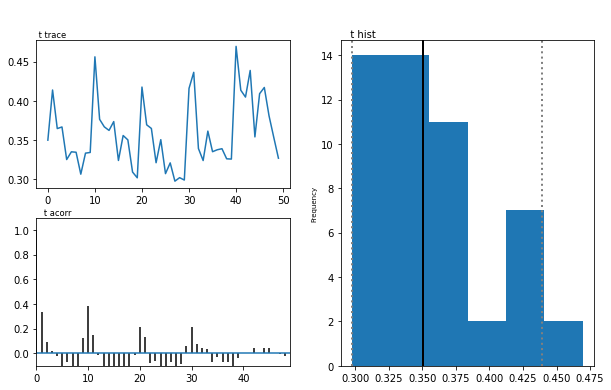

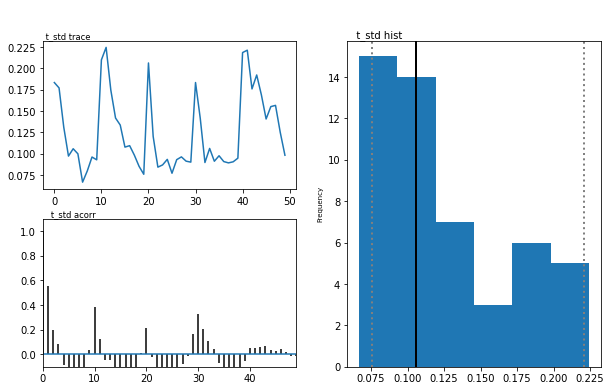

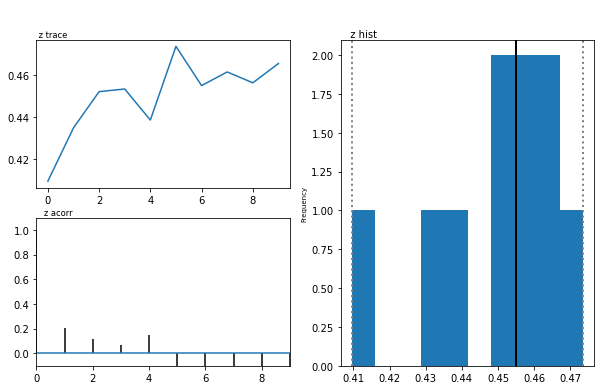

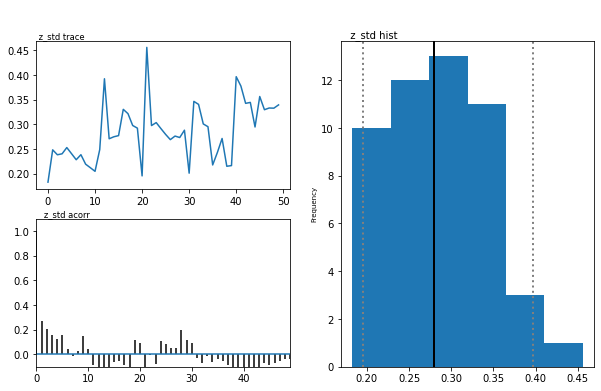

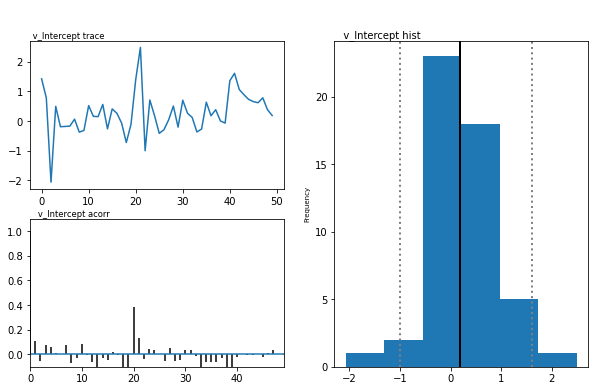

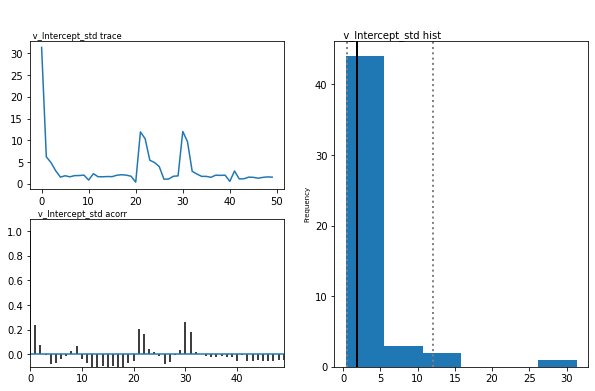

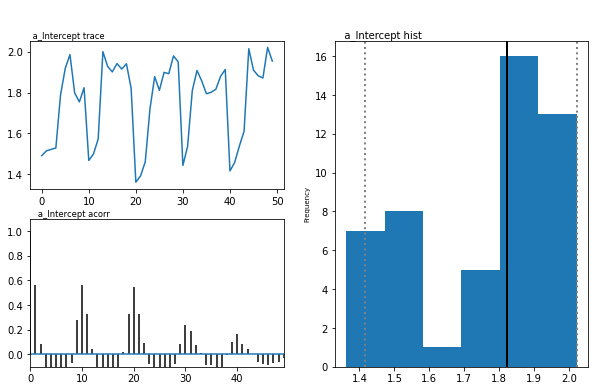

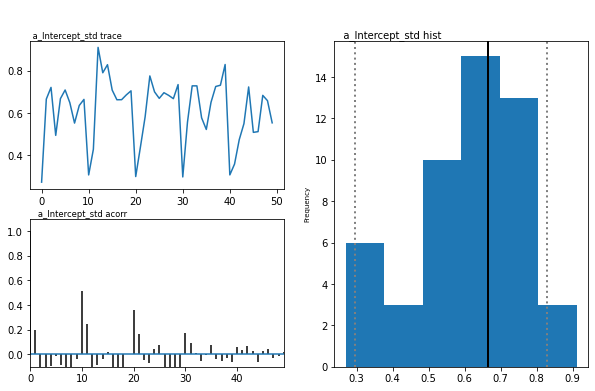

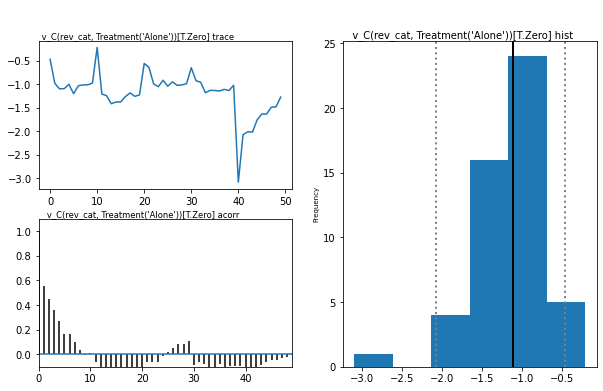

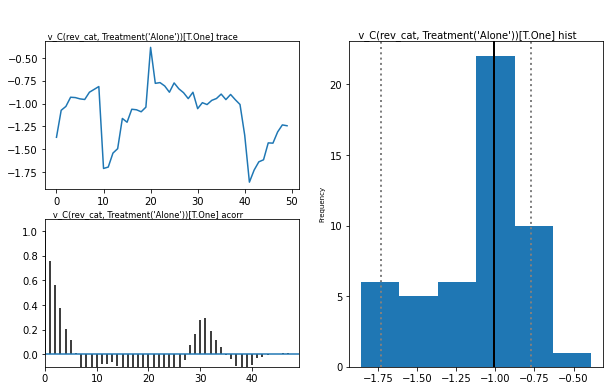

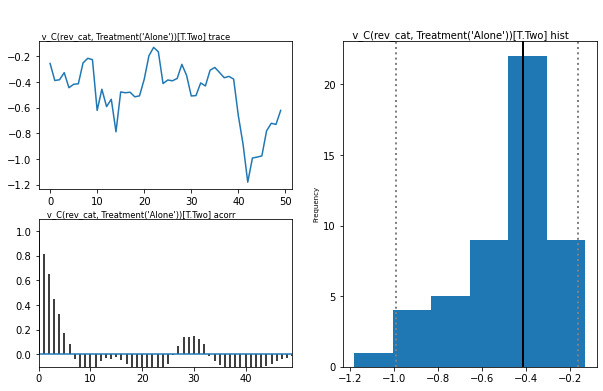

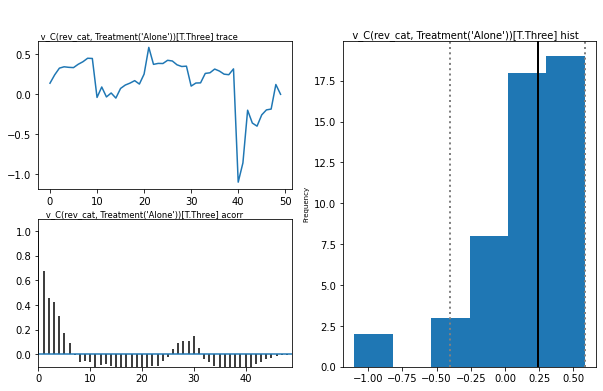

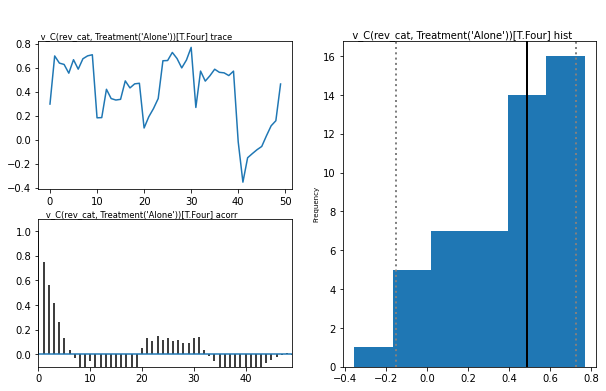

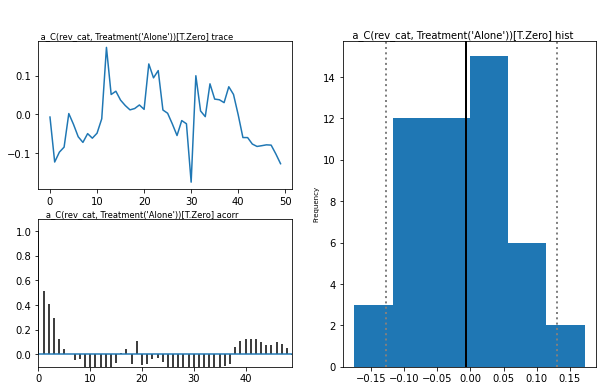

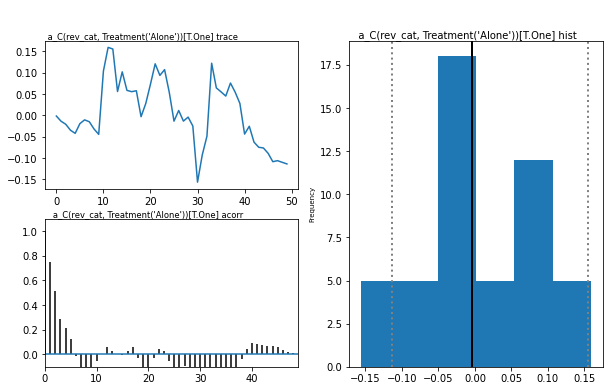

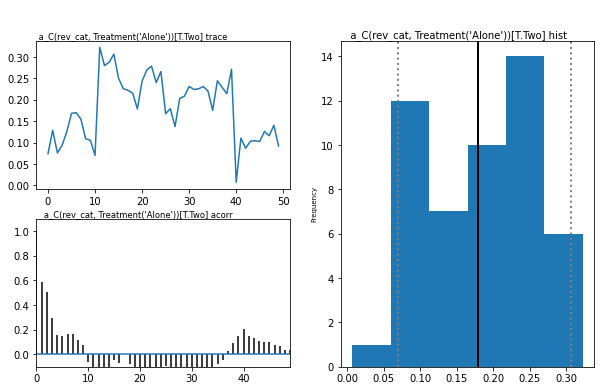

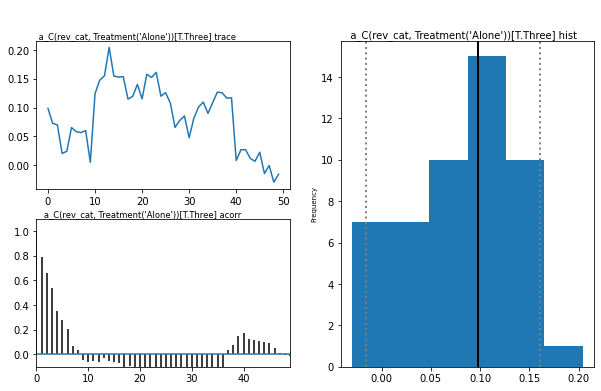

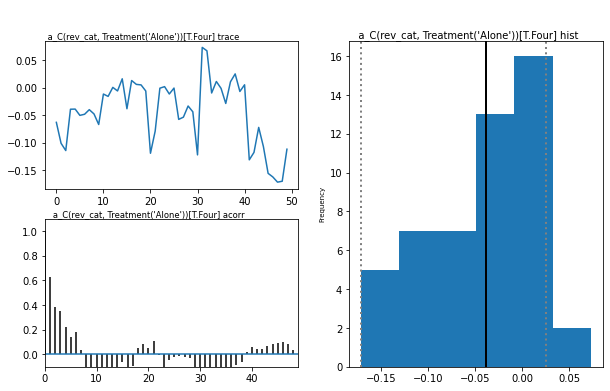

In [ ]:
#####  CHECK FOR CONVERGENCE

# Calculate Gelman-Rubin r-hat statistic
m_rhat = gelman_rubin(models)
pd.DataFrame.from_dict(m_rhat, orient='index').to_csv(basepath+'/Results/'+modelName+'_RHat.csv')

# Visual convergence check: list figures to be saved
# Change this according to what's in your model!
convergeCheck = [
't', 't_std',
'z', 'z_std',

'v_Intercept', 'v_Intercept_std',
'a_Intercept', 'a_Intercept_std',

'v_C(rev_cat, Treatment(\'Alone\'))[T.Zero]',
'v_C(rev_cat, Treatment(\'Alone\'))[T.One]',
'v_C(rev_cat, Treatment(\'Alone\'))[T.Two]',
'v_C(rev_cat, Treatment(\'Alone\'))[T.Three]',
'v_C(rev_cat, Treatment(\'Alone\'))[T.Four]',

'a_C(rev_cat, Treatment(\'Alone\'))[T.Zero]',
'a_C(rev_cat, Treatment(\'Alone\'))[T.One]',
'a_C(rev_cat, Treatment(\'Alone\'))[T.Two]',
'a_C(rev_cat, Treatment(\'Alone\'))[T.Three]',
'a_C(rev_cat, Treatment(\'Alone\'))[T.Four]'
]

# Save convergence figures
for i in convergeCheck:
    fig = m_comb.plot_posteriors(i)
    plt.savefig(basepath+'/Plots/' + modelName + '/' + i + '.pdf')

In [ ]:
#### SET UP ENVIRONMENT FOR PERFORMING POSTERIOR PREDICTIVE CHECKS

# Check whether save directories exist; if not, create them
pathlib.Path(basepath+'/PPC/').mkdir(parents=True, exist_ok=True)

# CUSTOM PATCHES SO YOU CAN GENERATE REGRESSION MODEL PREDICTIONS

import pymc as pm
import numpy as np
import pymc.progressbar as pbar

def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        sampled_data.reset_index(inplace=True)
        if append_data and data is not None:
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets

def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.loc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])

In [ ]:
##### POSTERIOR PREDICTIVE CHECK (PPC)

# Combine traces
all_m = concat_models(models)

# Generate predicted results from previously-estimated models
# Normally, we'd want to get many, many samples - I've done 1000 in the past
# But, for the sake of time, let's just do a couple
ppc_data = post_pred_gen(all_m, samples=2, append_data=True)
ppc_data.to_csv(basepath+'/PPC/'+modelName+'_simData.csv')

In [ ]:
##### PARAMETER RECOVERY

# Name this model
modelName_recovery = 'categorical_unfair_recovery20'  # Change this!


#####  SIMULATE DATA BASED ON PARAMETERS ESTIMATED FROM OBSERVED DATA

# Number of subjects matches that of the actual experiment
# For the number of trials per condition, you should run this twice:
#      Once with a small number of trials (or, the number of trials in your experiment), which lets you know whether
#           HDDM can reliably estimate the parameters given the amount of data you originally fed it
#      Once with a larger number of trials, which lets you know whether HDDM can reliably estimate the parameters as
#           the amount of data used to inform the computation approaches infinity
num_subs = 40
trials_per_cond = 20

# Drift rate estimates (empirical)
v_A = -0.2006909
v_0 = v_A + -0.7693828
v_1 = v_A + -0.6429486
v_2 = v_A + -0.1640435
v_3 = v_A + 0.4457329
v_4 = v_A + 0.6793762

# Threshold estimates
a_A = 2.1356529
a_0 = a_A + -0.1365446
a_1 = a_A + -0.1131092
a_2 = a_A + 0.0615770
a_3 = a_A + -0.0230197
a_4 = a_A + -0.1731338

# Bias and nondecision time estimates
z = 0.4410610
t = 0.3206254

# Define each condition and its corresponding parameters
params = {
    'rev_A': {'a':a_A, 't':t, 'v':v_A, 'z':z},
    'rev_0': {'a':a_0, 't':t, 'v':v_0, 'z':z},
    'rev_1': {'a':a_1, 't':t, 'v':v_1, 'z':z},
    'rev_2': {'a':a_2, 't':t, 'v':v_2, 'z':z},
    'rev_3': {'a':a_3, 't':t, 'v':v_3, 'z':z},
    'rev_4': {'a':a_4, 't':t, 'v':v_4, 'z':z}
}

# Now simulate that data
data, params = hddm.generate.gen_rand_data(
    params,
    size=trials_per_cond,
    subjs=num_subs,
    subj_noise=.1
)


#####  ESTIMATE SIMULATED PARAMETERS USING THE SAME REGRESSION MODEL
#####  USED TO ESTIMATE OBSERVED PARAMETERS

# Notes: Literally just copy/paste the regression model you used to estimate parameters. The point of doing this
#        analysis is to make sure that the combination of parameters you estimated from the empirical data are
#        parameters that HDDM is capable of reliably estimating. So given that we know exactly what the expected
#        parameter values are (since we simulated them), can HDDM then take that simulated data and give us an
#        estimate that's in the right ballpark?


# Create empty array that will eventually store our models
models_recovery = []

# Loop over 5 times to get 5 chains
for i in range(5):
    # Define regression model
    m_recovery = hddm.HDDMRegressor(data,
                           # Change this!
                           {"v ~ C(condition, Treatment('rev_A'))",
                            "a ~ C(condition, Treatment('rev_A'))"},
                           group_only_regressors=True,
                           p_outlier=.05,
                           include={'z'})
    m_recovery.find_starting_values()
    
    # Start sampling from the defined regression model
    #      For the sake of demonstration, we only collect 10 traces (not nearly enough)
    #      It's also conventional to discard/"burn" the first X traces, as they're typically not good estimates
    #      Instead of storing traces in RAM, we're going to save them to our hard drive
    m_recovery.sample(10, burn=0, dbname=basepath+'/Models/'+modelName_recovery+'_%s.db'%i, db='pickle')
    m_recovery.savePatch(basepath+'/Models/'+modelName_recovery+'_%s'%i)
    
    # Once you're finished running a chain, add that chain to your array of models
    models_recovery.append(m_recovery)


#####  GET STATS

# Calculate Gelman-Rubin r-hat statistic
m_recovery_rhat = gelman_rubin(models_recovery)
pd.DataFrame.from_dict(m_recovery_rhat, orient='index').to_csv(basepath+'/Results/'+modelName_recovery+'_RHat.csv')

# Save traces of concatenated model (only valid to look at if converged!)
m_comb_recovery = concat_models(models_recovery)
m_comb_recovery_export = m_comb_recovery.get_traces()
m_comb_recovery_export.to_csv(basepath+'/Results/'+modelName_recovery+'_traces.csv')